# Лабораторна робота №3


In [1]:
import re
import time
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Завдання перше: 1. Повнозв'язані нейронні мережі  
Візьміть дані, з якими ви працювали в лабораторній №1.  Побудуйте повнозв’язану нейронну мережу
прямого поширення для задачі класифікації.
Навчіть її на тренувальній вибірці, протестуйте на тестовій. Порівняйте результати з алгоритмами з Lab 1

In [ ]:
file_path = "academic Stress level - maintainance 1.csv"
df = pd.read_csv(file_path)
selected_columns = df.iloc[:, [2, 3, 7, 8]].copy()
df_clean = selected_columns.fillna(selected_columns.median())

In [ ]:
X = df_clean.iloc[:, :-1].values
y = df_clean.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=101, stratify=y
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train - 1) 
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test - 1)

In [ ]:
class StressClassifierNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(StressClassifierNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2) 
        self.layer2 = nn.Linear(32, 16)
        self.layer3 = nn.Linear(16, output_dim)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

In [ ]:
input_dim = X_train.shape[1] 
output_dim = 5               
model = StressClassifierNN(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

починаємо тренування моделі: 


In [ ]:
epochs = 300
loss_history = []

model.train()
for epoch in range(epochs):

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [50/300], Loss: 1.0176
Epoch [100/300], Loss: 0.9443
Epoch [150/300], Loss: 0.8526
Epoch [200/300], Loss: 0.8091
Epoch [250/300], Loss: 0.7615
Epoch [300/300], Loss: 0.6720


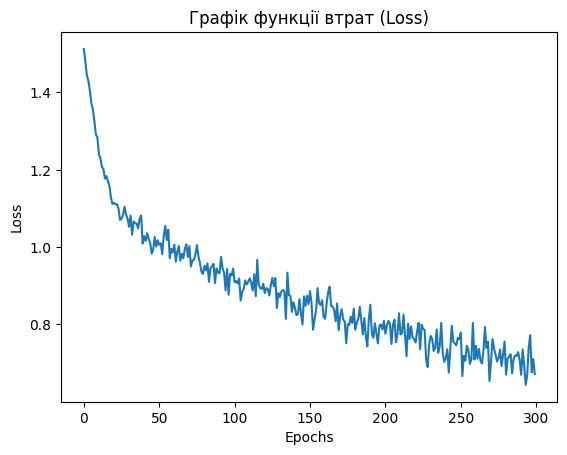

In [ ]:

plt.plot(loss_history)
plt.title('Графік функції втрат (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.eval() 
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    
    y_pred_numpy = predicted.numpy() + 1
    y_true_numpy = y_test_tensor.numpy() + 1

accuracy = accuracy_score(y_true_numpy, y_pred_numpy)
print(f"\nAccuracy (Neural Network): {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_true_numpy, y_pred_numpy, zero_division=0))


Accuracy (Neural Network): 0.3810

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.33      0.18      0.24        11
           4       0.38      0.59      0.47        17
           5       0.44      0.40      0.42        10

    accuracy                           0.38        42
   macro avg       0.23      0.23      0.22        42
weighted avg       0.35      0.38      0.35        42



Як ми бачимо macro avg тут 0.22, в той час як у першій лабораторній роботі:  
KNeighbors має 0.28,  
DecisionTree має 0.20,  
SVM(з жадібним пошуком) має 0.17,   
RandomForest має 0.38,   
і AdaBoost має 0.25.   
Легко бачити, що краща точність мається в RandomForest. 

Завдання 2: 

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 5     
IMG_SIZE = 224  

DATA_PATH = 'C:/Users/User/Python_projects/ds_lab3/Rice_Image_Dataset'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
print("Перевірка")
if not os.path.exists(DATA_PATH):
    print(f"Папки '{DATA_PATH}' нема")
else:
    full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform)
    
    classes = full_dataset.classes
    num_classes = len(classes)
    print(f"Знайдено класів: {num_classes}")
    print(f"Назви класів: {classes}") 

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Тренувальних зображень: {len(train_dataset)}")
    print(f"Валідаційних зображень: {len(val_dataset)}")

Перевірка
Знайдено класів: 5
Назви класів: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
Тренувальних зображень: 60000
Валідаційних зображень: 15000


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, model_name="Model"):
    print(f"\n Тренуємо: {model_name}")
    model = model.to(device)
    history = {'train_loss': [], 'val_acc': [], 'train_time': 0}
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        acc = 100 * correct / total
        history['val_acc'].append(acc)
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Acc: {acc:.2f}%")
        
    end_time = time.time()
    history['train_time'] = end_time - start_time
    print(f"Тренування {model_name} закінченно {history['train_time']:.2f} сек.")
    return history

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        #  3 в 16 каналів
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2) 
        
        # 16 в 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2) 
        
        # 32 в 64
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2) # 56 -> 28 пікселів

        self.flatten_size = 64 * 28 * 28 
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.act4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes) 

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        
        x = x.view(x.size(0), -1) 
        x = self.act4(self.fc1(x))
        x = self.fc2(x)
        return x

if 'full_dataset' in locals():
    model_a = SimpleCNN(num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer_a = optim.Adam(model_a.parameters(), lr=LEARNING_RATE)
    
    history_a = train_model(model_a, train_loader, val_loader, criterion, optimizer_a, epochs=EPOCHS, model_name="Custom CNN")


 Тренуємо: Custom CNN
Epoch [1/5], Loss: 0.1017, Val Acc: 98.87%
Epoch [2/5], Loss: 0.0320, Val Acc: 99.07%
Epoch [3/5], Loss: 0.0192, Val Acc: 98.64%
Epoch [4/5], Loss: 0.0179, Val Acc: 99.61%
Epoch [5/5], Loss: 0.0133, Val Acc: 98.91%
Тренування Custom CNN закінченно 1835.65 сек.


In [ ]:
if 'full_dataset' in locals():

    weights = models.ResNet18_Weights.DEFAULT
    model_b = models.resnet18(weights=weights)

    for param in model_b.parameters():
        param.requires_grad = False

    num_ftrs = model_b.fc.in_features
    model_b.fc = nn.Linear(num_ftrs, num_classes)

    optimizer_b = optim.Adam(model_b.fc.parameters(), lr=LEARNING_RATE)
    
    history_b = train_model(model_b, train_loader, val_loader, criterion, optimizer_b, epochs=EPOCHS, model_name="ResNet18")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%



 Тренуємо: ResNet18
Epoch [1/5], Loss: 0.1570, Val Acc: 97.85%
Epoch [2/5], Loss: 0.0776, Val Acc: 98.12%
Epoch [3/5], Loss: 0.0638, Val Acc: 98.13%
Epoch [4/5], Loss: 0.0603, Val Acc: 98.76%
Epoch [5/5], Loss: 0.0571, Val Acc: 98.71%
Тренування ResNet18 закінченно 1191.65 сек.


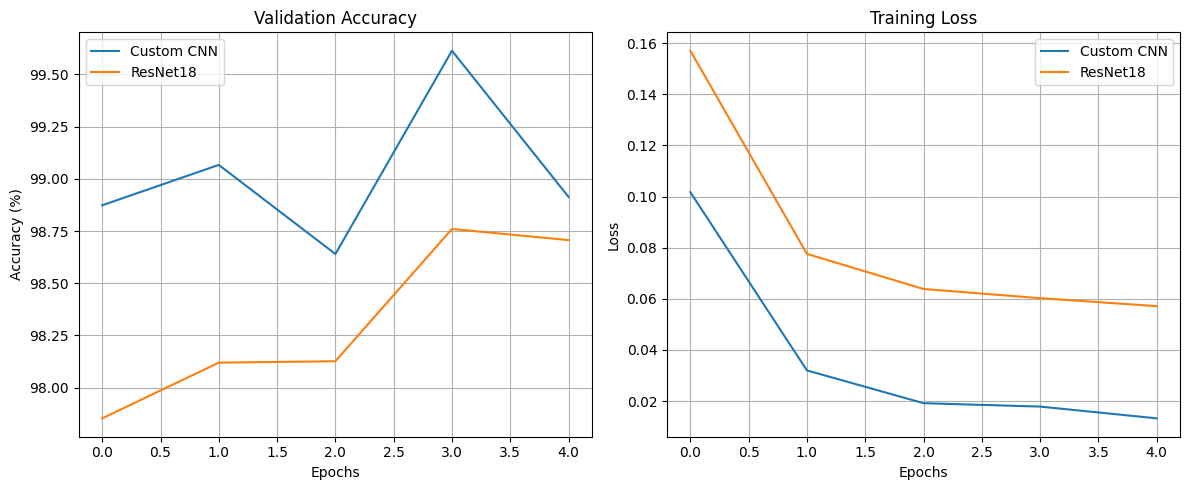

Custom CNN -> Точність: 98.91%, Час: 1835.65 сек.
ResNet18   -> Точність: 98.71%, Час: 1191.65 сек.


In [ ]:
if 'history_a' in locals() and 'history_b' in locals():
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_a['val_acc'], label='Custom CNN')
    plt.plot(history_b['val_acc'], label='ResNet18')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history_a['train_loss'], label='Custom CNN')
    plt.plot(history_b['train_loss'], label='ResNet18')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Custom CNN -> Точність: {history_a['val_acc'][-1]:.2f}%, Час: {history_a['train_time']:.2f} сек.")
    print(f"ResNet18   -> Точність: {history_b['val_acc'][-1]:.2f}%, Час: {history_b['train_time']:.2f} сек.")

Завдання 3: Вирішіть задачу класифікації текстів (використайте той же датасет, з яким ви працювали в лабораторній № 2) двома способами:  
а) Побудуйте модель з вбудованим Embedding шаром (ініціалізованим випадковими вагами). Використайте RNN / LSTM / GRU для класифікації. Навчіть модель на вашому датасеті.  
б) Завантажте готові embeddings (наприклад, GloVe). Ініціалізуйте Embedding шар цими вагами. Проведіть навчання.  
Порівняйте якість класифікації у (а) та (б). Чи покращилися метрики при використанні pretrained embeddings? Наскільки швидше/стабільніше відбулося навчання?


In [2]:
TRAIN_PATH = "C:/Users/User/Python_projects/ds_lab2/train.ft.txt"
TEST_PATH = "C:/Users/User/Python_projects/ds_lab2/test.ft.txt"
GLOVE_FILE = "glove.twitter.27B.50d.txt"
MAX_SEQ_LEN = 100    
EMBED_DIM = 50      
HIDDEN_DIM = 128
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 5
MAX_SAMPLES = 20000

In [5]:
def load_fasttext(path, max_samples=None):
    texts = []
    labels = []
    print(f"Завантаження {path}...")
    if not os.path.exists(path):
        print(f"ПОМИЛКА: Файл {path} не знайдено!")
        return [], []
        
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_samples and i >= max_samples:
                break
            label, text = line.split(" ", 1)
            labels.append(label.replace("__label__", "").strip())
            texts.append(text.strip())
    return texts, labels

train_texts, train_labels_str = load_fasttext(TRAIN_PATH, MAX_SAMPLES)
test_texts, test_labels_str = load_fasttext(TEST_PATH, int(MAX_SAMPLES * 0.2) if MAX_SAMPLES else None)

if len(train_texts) == 0:
    raise ValueError("Дані не завантажено. Перевірте шляхи до файлів!")

Завантаження C:/Users/User/Python_projects/ds_lab2/train.ft.txt...
Завантаження C:/Users/User/Python_projects/ds_lab2/test.ft.txt...


In [6]:
unique_labels = sorted(list(set(train_labels_str)))
label_map = {label: i for i, label in enumerate(unique_labels)}
print(f"Знайдені класи: {unique_labels} -> Мапимо в: {label_map}")

train_labels = [label_map[l] for l in train_labels_str]
test_labels = [label_map[l] for l in test_labels_str]
num_classes = len(unique_labels)

print("Побудова словника...")
def tokenize(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

all_words = []
for text in train_texts:
    all_words.extend(tokenize(text))

word_counts = Counter(all_words)
vocab = {word: i+2 for i, (word, count) in enumerate(word_counts.most_common(20000))} # Обмежимо словник топ-20к слів
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1
vocab_size = len(vocab)
print(f"Розмір словника: {vocab_size}")

Знайдені класи: ['1', '2'] -> Мапимо в: {'1': 0, '2': 1}
Побудова словника...
Розмір словника: 20002


In [7]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = tokenize(text)
        indices = [self.vocab.get(t, self.vocab['<UNK>']) for t in tokens]

        if len(indices) < self.max_len:
            indices += [self.vocab['<PAD>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
            
        return torch.tensor(indices, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)
    
train_dataset = TextDataset(train_texts, train_labels, vocab, MAX_SEQ_LEN)
test_dataset = TextDataset(test_texts, test_labels, vocab, MAX_SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, pretrained_embeddings=None):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = False # Заморозити ваги глова
        
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden[-1])

In [9]:
def train_eval(model, train_loader, test_loader, epochs=5, name="Model"):
    print(f"\nЗапуск навчання: {name}")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    history = {'acc': [], 'loss': []}
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for text, label in train_loader:
            text, label = text.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(text)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for text, label in test_loader:
                text, label = text.to(device), label.to(device)
                output = model(text)
                _, predicted = torch.max(output, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
        
        acc = 100 * correct / total
        avg_loss = total_loss / len(train_loader)
        history['acc'].append(acc)
        history['loss'].append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Test Acc = {acc:.2f}%")
        
    return history

In [12]:
model_a = LSTMClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, num_classes)
history_a = train_eval(model_a, train_loader, test_loader, epochs=EPOCHS, name="Random Init")


Запуск навчання: Random Init
Epoch 1: Loss = 0.6927, Test Acc = 54.15%
Epoch 2: Loss = 0.6867, Test Acc = 53.25%
Epoch 3: Loss = 0.6680, Test Acc = 54.30%
Epoch 4: Loss = 0.6516, Test Acc = 53.85%
Epoch 5: Loss = 0.6535, Test Acc = 65.15%


In [10]:
def load_glove_matrix(glove_file, vocab, embed_dim):
    if not os.path.exists(glove_file):
        print(f"GloVe файл '{glove_file}' не знайдено. Пропускаємо.")
        return None
    
    print("Завантаження матриці GloVe...")
    embeddings_index = {}
    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if len(values) > embed_dim: 
                 coefs = np.asarray(values[1:], dtype='float32')
                 embeddings_index[word] = coefs
    
    matrix = torch.zeros((len(vocab), embed_dim))
    hits = 0
    for word, i in vocab.items():
        vec = embeddings_index.get(word)
        if vec is not None:
            matrix[i] = torch.from_numpy(vec)
            hits += 1
    print(f"Знайдено слів з GloVe: {hits}")
    return matrix

glove_matrix = load_glove_matrix(GLOVE_FILE, vocab, EMBED_DIM)

Завантаження матриці GloVe...
Знайдено слів з GloVe: 18250



Запуск навчання: GloVe Init
Epoch 1: Loss = 0.6372, Test Acc = 68.85%
Epoch 2: Loss = 0.6812, Test Acc = 52.08%
Epoch 3: Loss = 0.6585, Test Acc = 59.02%
Epoch 4: Loss = 0.6718, Test Acc = 56.02%
Epoch 5: Loss = 0.6653, Test Acc = 53.95%


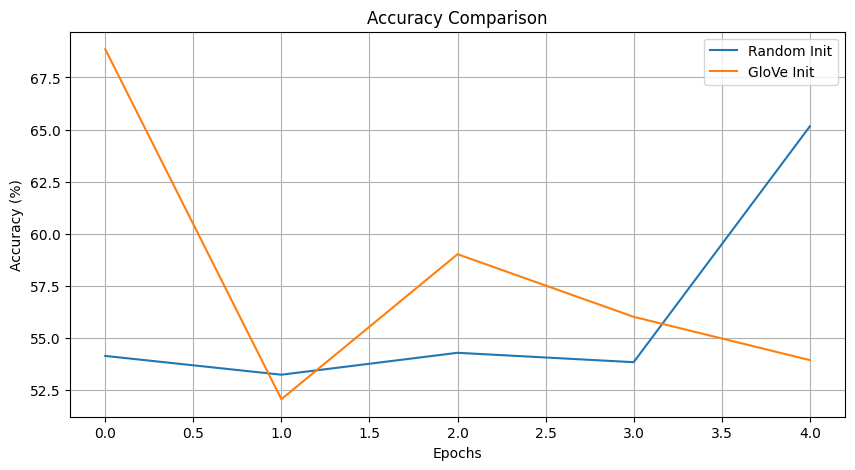

In [13]:
if glove_matrix is not None:
    model_b = LSTMClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, num_classes, pretrained_embeddings=glove_matrix)
    history_b = train_eval(model_b, train_loader, test_loader, epochs=EPOCHS, name="GloVe Init")

    plt.figure(figsize=(10,5))
    plt.plot(history_a['acc'], label='Random Init')
    plt.plot(history_b['acc'], label='GloVe Init')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("упс, нема глова")